In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -uq '/content/drive/MyDrive/Colab Notebooks/HURJC-main.zip'

In [3]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
import os, warnings
from matplotlib import gridspec
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
import math
import skimage.exposure
from skimage.transform import resize

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout
import glob
import seaborn as sns
import cv2
from skimage.color import rgb2gray

%matplotlib inline

In [4]:
labels_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/calcific_tendinopathy_ddbb (5).xlsx')

In [5]:
labels = np.array(labels_df['calcium'].tolist())
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0]


In [6]:
labels_df.head(105)

,image,calcium,pat_id,type,localization
0,001065097F_001.png,1,1065097F,2,supraespinoso
1,001065097F_002.png,1,1065097F,2,supraespinoso
2,001079917Z_001.png,1,1079917Z,1,supraespinoso e infraespinoso
3,001079917Z_002.png,1,1079917Z,1,supraespinoso e infraespinoso
4,001120686Z_001.png,1,1120686Z,2,infraespinoso
...,...,...,...,...,...
95,0080723MHD_002.png,1,80723MHD,3,supraespinoso
96,0094847_001.png,0,94847,-1,NaN
97,00RCV_001.png,1,RCV,3,supraespinoso
98,00RCV_002.png,1,RCV,3,supraespinoso


In [7]:
labels_df.describe()

,calcium,type
count,100.000000,100.000000
mean,0.780000,1.550000
std,0.416333,1.635311
min,0.000000,-1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,3.000000
max,1.000000,4.000000


In [8]:
files = sorted(glob.glob('/content/HURJC-main/database/*.png'))

In [9]:
images = []
for path in files:
  img = io.imread(path)
  img_rgb2gray=rgb2gray(img)
  images.append(resize(img_rgb2gray,(250,250,3)))

In [10]:
images = np.array(images)

In [11]:
images.shape

(100, 250, 250, 3)

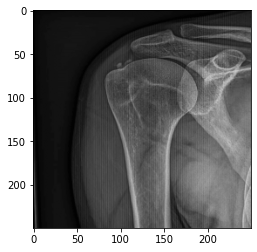

In [12]:
plt.imshow(images[0])

In [13]:
print(labels)
print(labels.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0]
(100,)


In [14]:
#indicies = np.random.permutation(100) #Aleatorización de las imágenes
#train_true_idx, test_true_idx = indicies[:90], indicies[90:] #90 imágenes de 1s en train, y 10 imágenes de 1s en test, todas ellas elegidas aleatoriamente de la primera mitad (100) de 1s

#train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100 #90 imágenes de 0s en train, y 10 imágenes de 0s en test, todas ellas elegidas aleatoriamente de la segunda mitad (100) de 0s
#train_idx, test_idx = train_true_idx, test_true_idx #Juntamos los 0s y los 1s en sus grupos correspondientes (train y test)

train_validationX, train_validationY = images[:90], labels[:90] #Primer conjunto que contiene las imágenes de train y validación
testX, testY = images[90:], labels[90:] #Segundo conjunto que contiene las imágenes de test

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(90, 250, 250, 3) (10, 250, 250, 3)
(90,) (10,)


In [15]:
trainX, validX, trainY, validY = train_test_split(train_validationX, train_validationY, test_size=0.2, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


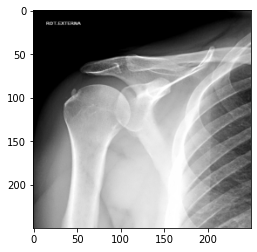

In [16]:
plt.imshow(trainX[0])

In [17]:
train_image_data = ImageDataGenerator(
    zoom_range=0.05, #Zoom aleatorio sobre las imágenes
    #rotation_range=180, #Rotación de las imágenes
    width_shift_range=0.05, #Fracción de anchura total
    height_shift_range=0.05, #Fracción de altura total
    horizontal_flip=True, #Voltear horizontalmente
    vertical_flip=True, #Voltear verticalmente
    #fill_mode='constant', #Tipo de relleno para los inputs que están fuera de los límites
    #cval=0 #Valor usado para rellenar los inputs fuera de los límites
    )
validation_image_data = ImageDataGenerator(
    zoom_range=0.05, #Zoom aleatorio sobre las imágenes
    #rotation_range=180, #Rotación de las imágenes
    width_shift_range=0.05, #Fracción de anchura total
    height_shift_range=0.05, #Fracción de altura total
    horizontal_flip=True, #Voltear horizontalmente
    vertical_flip=True, #Voltear verticalmente
    #fill_mode='constant', #Tipo de relleno para los inputs que están fuera de los límites
    #cval=0 #Valor usado para rellenar los inputs fuera de los límites
    )


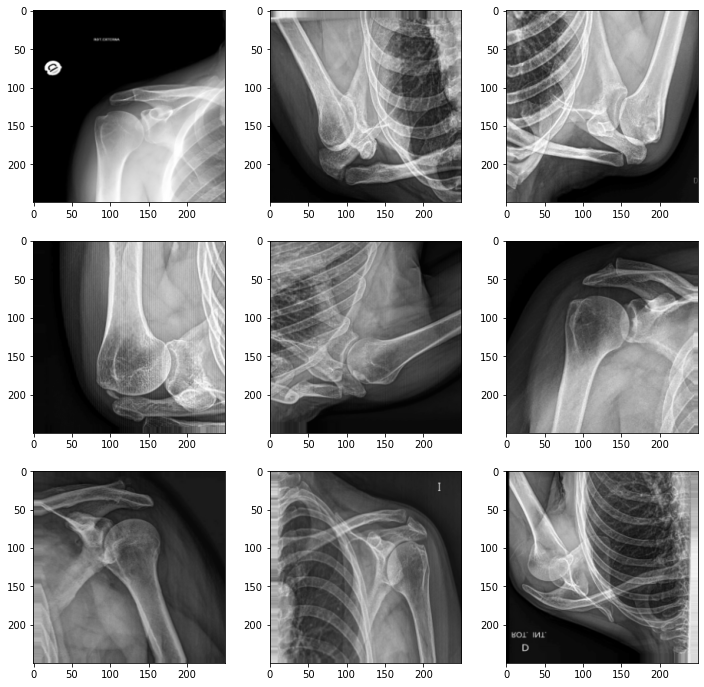

In [18]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i],cmap='gray')
    plt.show()
    break

In [19]:
from sklearn.metrics import classification_report
def check_accuracy(model, setX, actual, print_images=True): 
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)]) #Guardamos en la variable predicted la predicción (0 o 1) de nuestro modelo sobre las imágenes
    if print_images: #Generamos las imágenes con la etiqueta predicha y la verdadera
        rows = math.ceil(len(predicted)/10.) 
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)): 
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
    target_names = ['class 0', 'class 1'] 
    print(classification_report(actual, predicted, target_names=target_names))    
    confusion = confusion_matrix(actual, predicted) #Guardamos en confusion la matriz de confusión generada
    tn, fp, fn, tp = confusion.ravel() #Asignamos cada elemento de la matriz
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%") 
    return (tn, fp, fn, tp)

In [20]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(250, 250, 3))

83689472/83683744 [==============================] - 0s 0us/step


In [21]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 124, 124, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 124, 124, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [22]:
#add two dense layers on top of the conv_base
model = models.Sequential() 
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu',name = 'dense_layer'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid',name = 'output_layer'))
#x = layers.Dense(64, activation='relu',name = 'dense_layer')(new_model.output)
#output = layers.Dense(1,activation = "sigmoid",name = 'output_layer')(new_model.output)

#model = Model(new_model.inputs,output)


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense_layer (Dense)          (None, 256)               33554688  
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 54,417,449
Trainable params: 54,362,409
Non-trainable params: 55,040
_______________________________________

In [23]:
#Congelamos los pesos de la base preentrenada
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 6


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense_layer (Dense)          (None, 256)               33554688  
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 257       
Total params: 54,417,449
Trainable params: 33,555,457
Non-trainable params: 20,861,992
___________________________________

In [25]:
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [26]:
train_batch_size = 12
val_batch_size = 7

train_generator = train_image_data.flow(
    trainX,
    trainY,
    batch_size=train_batch_size)

validation_generator = validation_image_data.flow( 
    validX,
    validY,
    batch_size=val_batch_size)

In [27]:
print(np.unique(trainY))
print(trainY)

[0 1]
[0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0]


In [28]:
from sklearn.utils import class_weight
steps_per_epoch = train_generator.n // train_batch_size
validation_steps = validation_generator.n // val_batch_size
class_weights = class_weight.compute_class_weight('balanced',np.unique(trainY),trainY)

#class_weights=class_weight.compute_class_weight('balanced',np.unique(trainY),trainY)
#class_weights= {i : class_weights[i] for i in range(2)}
class_weights={0:3, 1:0.6}
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    #callbacks=model_checkpoint_callback,
                    class_weight=class_weights,
                    epochs=100)

Epoch 1/100
6/6 [==============================] - 12s 466ms/step - loss: 1.7390 - binary_accuracy: 0.5016 - val_loss: 3.8591 - val_binary_accuracy: 0.7143
Epoch 2/100
6/6 [==============================] - 1s 211ms/step - loss: 0.9527 - binary_accuracy: 0.5863 - val_loss: 1.9398 - val_binary_accuracy: 0.8571
Epoch 3/100
6/6 [==============================] - 1s 210ms/step - loss: 0.6064 - binary_accuracy: 0.6456 - val_loss: 0.3426 - val_binary_accuracy: 0.9286
Epoch 4/100
6/6 [==============================] - 1s 212ms/step - loss: 0.5701 - binary_accuracy: 0.6841 - val_loss: 1.0350 - val_binary_accuracy: 0.7857
Epoch 5/100
6/6 [==============================] - 1s 217ms/step - loss: 0.4816 - binary_accuracy: 0.6296 - val_loss: 0.2787 - val_binary_accuracy: 0.9286
Epoch 6/100
6/6 [==============================] - 1s 209ms/step - loss: 0.5412 - binary_accuracy: 0.6002 - val_loss: 0.8387 - val_binary_accuracy: 0.7857
Epoch 7/100
6/6 [==============================] - 1s 216ms/step - lo

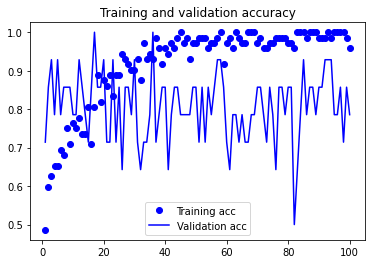

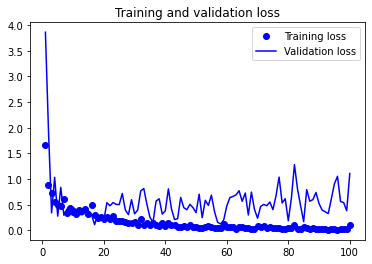

In [29]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

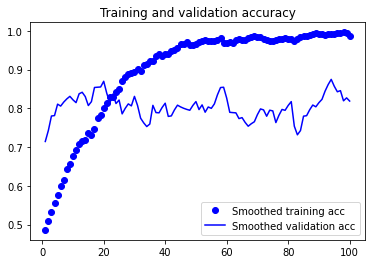

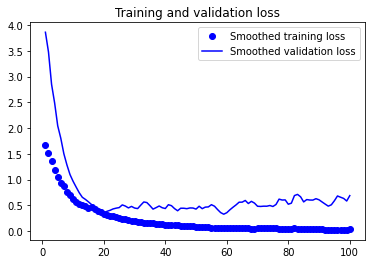

In [30]:
def smooth_curve(points, factor=0.8): 
  smoothed_points = []
  for point in points:
      if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
      else: 
          smoothed_points.append(point)
  return smoothed_points
plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss') 
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

     class 0       0.50      0.33      0.40         3
     class 1       0.75      0.86      0.80         7

    accuracy                           0.70        10
   macro avg       0.62      0.60      0.60        10
weighted avg       0.68      0.70      0.68        10

True positive: 6 , True negative: 1 , False positive: 2 , False negative: 1
Total accuracy: 70.0 %


(1, 2, 1, 6)

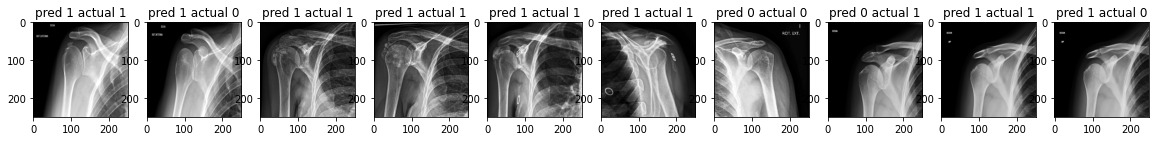

In [31]:
check_accuracy(model, testX, testY)